## Accessing NASADEM data using the Planetary Computer STAC API

[NASADEM](https://earthdata.nasa.gov/esds/competitive-programs/measures/nasadem) provides global topographic data at 1 arc-second (~30m) horizontal resolution, derived primarily from data captured via the [Shuttle Radar Topography Mission](https://www2.jpl.nasa.gov/srtm/) (SRTM).

NASADEM is hosted on Azure in both NetCDF and cloud-optimized GeoTIFF (COG) formats; this notebook demonstrates access to the COG-formatted data via the Planetary Computer STAC API.

This dataset is stored in the West Europe Azure region, so this notebook will run most efficiently on Azure compute located in the same region.  If you are using this data for environmental science applications, consider applying for an [AI for Earth grant](http://aka.ms/ai4egrants) to support your compute requirements.

This dataset is documented on the [Planetary Computer data catalog](https://planetarycomputer.microsoft.com/dataset/nasadem).

### Environment Setup

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key. The Planetary Computer Hub is pre-configured to use your API key.

In [1]:
from datashader.transfer_functions import shade, stack
from datashader.colors import Elevation
from pystac_client import Client
from xrspatial import hillshade

import planetary_computer as pc
import xarray as xr

### Querying the dataset

NASADEM data on the Planetary Computer is available globally. We can define a few well known points of interest to find the corresponding DEM data. 

In [2]:
# Interesting places for looking at SRTM data
everest = [86.9250, 27.9881]
seattle = [-122.332, 47.6062]
grand_canyon = [-112.107676, 36.101690]
mount_fuji = [138.7274, 35.3606]
mont_blanc = [6.865000, 45.832778]

areas_of_interest = {"type": "Point", "coordinates": everest}

Execute a STAC API query for our selected point.

In [3]:
# TODO: staging
catalog = Client.open("https://planetarycomputer-staging.microsoft.com/api/stac/v1")
nasadem = catalog.search(collections=["nasadem"], intersects=areas_of_interest)

items = [item for item in nasadem.get_items()]

print(f"Returned {len(items)} Items")

Returned 1 Items


What's actually getting returned? In the STAC API, each item has a list of assets with an href to where the underlying file is stored. Here we can see that NASADEM items have a single asset, `elevation`.

In [4]:
item = items[0]
print(item.assets)

{'elevation': <Asset href=https://nasademeuwest.blob.core.windows.net/nasadem-cog/v001/NASADEM_HGT_n27e086.tif>}


### Read and plot a NASADEM tile

We found an asset that marched our seach, so we'll open the GeoTIFF directly with xarray and downlsample the data for easier plotting. The `datashader` render can handle rendering the whole array, but the resulting image size is quite large. 

In [5]:
signed_asset = pc.sign(item.assets["elevation"])

da = (
    xr.open_rasterio(signed_asset.href)
    .squeeze()
    .drop("band")[:-1, :-1]
    .coarsen({"y": 5, "x": 5})
    .mean()
)

Now we can generate a shaded relief using [xarray-spatial](https://xarray-spatial.org/user_guide/surface.html).

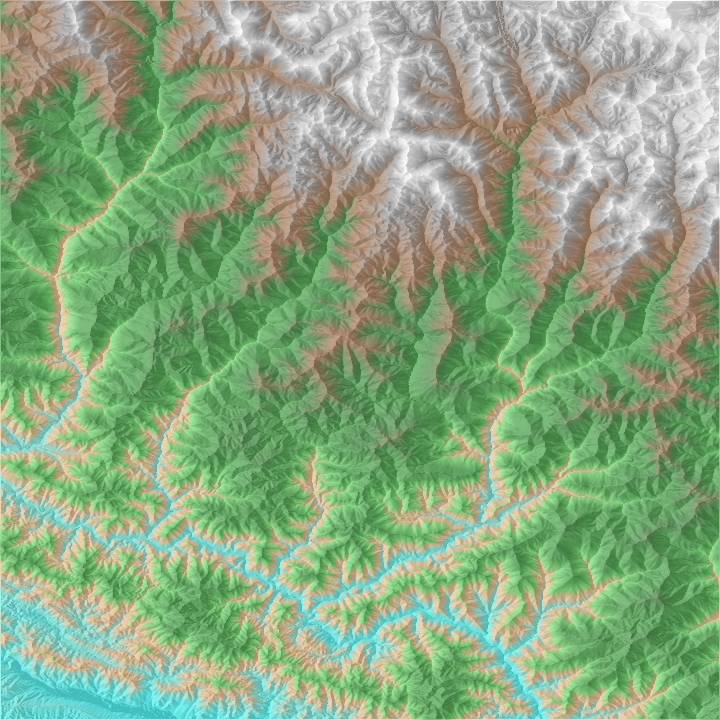

In [6]:
# Render the hillshade with a coloramp of the values applied on top
shaded = hillshade(da, azimuth=100, angle_altitude=50)
stack(shade(shaded, cmap=["white", "gray"]), shade(da, cmap=Elevation, alpha=128))